In [ ]:
# Standard Libraries and Utilities
import os
import sys
import numpy as np
from tqdm import tqdm

# Image Processing and File Handling
import cv2
from glob import glob
import tifffile as tiff
from tifffile import imread

# Plotting and Visualization
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["image.interpolation"] = None  # Set interpolation to None for matplotlib

# StarDist and Related Image Analysis Libraries
from stardist import fill_label_holes, random_label_cmap
from stardist.models import StarDist2D, Config2D
from stardist.matching import matching, matching_dataset

# CSBDeep (for Image Restoration and Normalization)
from csbdeep.utils import normalize

# TensorFlow/Keras Specific Utilities (If GPU Usage is Required)
# Uncomment the following lines if you are using GPU acceleration
# from csbdeep.utils.tf import keras_import
# LambdaCallback = keras_import('callbacks', 'LambdaCallback')

Loading Training Images and Masks

This section of the script is focused on loading and preparing training images and masks for image processing models. It involves setting up a random color map and loading image data from specified directories.
Steps:

   - Set Random Seed: To ensure reproducibility, a random seed is set using np.random.seed(42). This affects the random processes in the script.

   - Create Random Label Color Map: A random label color map is created for visualization purposes using random_label_cmap() from the stardist library.

   - Specify File Paths: Paths to the directories containing training images (fX) and masks (fY) are defined. These paths should be adjusted based on your file system structure.

   - Load File Paths: Using Python's Path object and glob, all TIFF files (*.tif) in the specified directories are located and listed.

   - Print File Counts: The script outputs the count of training images and masks found, which helps in verifying that the files have been correctly loaded.

   - Select a Subset of Data: For demonstration or initial testing, a smaller subset of the data (the first 10 images and masks) is selected.

   - Read Images and Masks: The training images and masks are read into memory. This converts file paths into actual image data that can be processed.

In [ ]:
# Initialize random seed for consistency in color mapping
np.random.seed(42)

# Create a random label color map for visualization
lbl_cmap = random_label_cmap()

# Define paths to training images and masks
fX = sorted(Path('C:/.../images/').glob('*.tif'))
fY = sorted(Path('C:/.../masks').glob('*.tif'))

# Display the count of training images and masks found
print(f"found {len(fX)} training images and {len(fY)} training masks")

# Select a smaller subset of the data for quick testing
fX_small, fY_small = fX[:10], fY[:10]

# Load the images and masks into memory
X_small = list(map(imread, map(str, fX)))
Y_small = list(map(imread, map(str, fY)))


Visualizing Training Image and Corresponding Mask

This section of the script is dedicated to visualizing a training image along with its corresponding ground truth mask (label). This is essential for verifying the correctness of the data and understanding how the images and masks align.
Steps:

   - Select an Image: Choose an image from the dataset for visualization. i = min(50, len(X_small)-1) ensures that the index is within the bounds of the dataset.

   - Process the Image and Label: The selected image and its corresponding label are loaded. The label is processed with fill_label_holes to ensure better visualization.

   - Image Dimension Check: The script asserts that the image has either 2 or 3 dimensions, which correspond to grayscale or color images, respectively.

   - Handle Color Images: If the image has 3 dimensions (color), only the first three channels are used. This is relevant for RGB images.

   - Plotting: The image and its mask are plotted side by side for easy comparison. The image is displayed in grayscale, and the mask uses the previously created random color map.

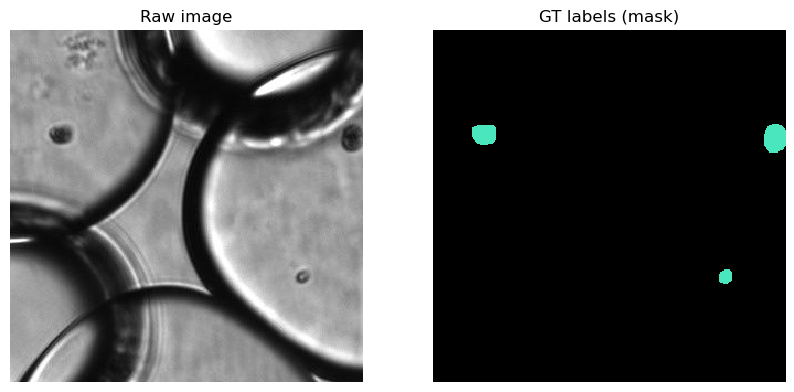

In [11]:
# Select an image for visualization (index i)
i = min(50, len(X_small)-1)
img, lbl = X_small[i], fill_label_holes(Y_small[i])

# Ensure that the image has either 2 (grayscale) or 3 (color) dimensions
assert img.ndim in (2, 3)

# If it's a color image, use only the first three channels (RGB)
img = img if img.ndim == 2 else img[..., :3]

# Set up the plotting environment
plt.figure(figsize=(10, 8))

# Plot the raw image
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Raw image')

# Plot the ground truth labels (mask)
plt.subplot(122)
plt.imshow(lbl, cmap=lbl_cmap, interpolation="nearest")
plt.axis('off')
plt.title('GT labels (mask)')

# Prevent output of plot object
None;

Preparing Image Data for Segmentation

In this part of the script, we set up important parameters and read a series of training images and masks from specified directories. This setup is crucial for image segmentation tasks.
Steps:

   - Define Number of Rays: The n_rays variable is a list that holds different powers of 2, starting from 2^2 up to 2^7. These values are often used in star-convex shape representations in image segmentation.

   - Load Image and Mask File Paths: The paths to the training images (X) and masks (Y) are specified. Make sure these paths point to your dataset.

   - Read Images and Masks: The images and masks are loaded into memory using the imread function from the tifffile library, which is specifically designed for .tif images.

   - Determine Number of Channels: The script checks the dimensionality of the images to determine whether they are grayscale (2D) or color (3D). The number of channels is set accordingly.

In [12]:
# Define a list of numbers representing the number of rays (for star-convex shapes)
n_rays = [2**i for i in range(2, 8)]
print(n_rays)

# Define paths to image and mask directories and sort them
X = sorted(glob('C:/.../images/*.tif'))
Y = sorted(glob('C:/.../masks/*.tif'))

# Load images and masks using their paths
X = list(map(imread, X))
Y = list(map(imread, Y))

# Determine the number of channels in the images
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  # 1 for grayscale, number of channels for color
n_channel

[4, 8, 16, 32, 64, 128]


Image Normalization and Mask Processing

In this segment, the script normalizes the training images and fills holes in the segmentation masks. Normalization is crucial for consistent image processing, especially when working with diverse datasets.
Steps:

   - Set Normalization Axis: The axis_norm variable determines how the normalization is applied. If set to (0,1), it normalizes channels independently. If set to (0,1,2), it normalizes channels jointly.

   - Channel Normalization Logic: The script checks the number of channels in the images. If there are multiple channels, it prints out whether the channels will be normalized independently or jointly, based on axis_norm.

   - Normalize Images: Each image in X is normalized using the normalize function from the csbdeep library. The parameters 1 and 99.8 define the percentiles for normalization.

   - Process Masks: Each mask in Y is processed using fill_label_holes from stardist. This step is important for creating cleaner segmentation masks.

In [26]:
# Define the axis for normalization
axis_norm = (0, 1)  # Normalize channels independently

# Print out normalization approach based on the number of channels and axis_norm
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

# Normalize each image in the dataset
X = [normalize(x, 1, 99.8, axis=axis_norm) for x in tqdm(X)]

# Fill holes in each mask in the dataset
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 612/612 [00:00<00:00, 2498.84it/s]


Splitting Dataset into Training and Validation Sets

This section of the script deals with dividing the dataset into training and validation subsets. This split is vital for training robust models and evaluating their performance.
Steps:

   - Check Dataset Size: The script first ensures that there are enough images for training. An assertion is used for this check.

   - Random Seed for Reproducibility: A random number generator (rng) is initialized with a fixed seed for reproducibility.

   - Random Permutation of Indices: The indices of the images are shuffled randomly. This step is crucial for ensuring that the training and validation sets are randomly selected.

   - Calculate Validation Set Size: The size of the validation set is determined as 15% of the total dataset, which is a common practice in machine learning.

   - Split Indices: The indices are split into training and validation sets. The validation set comprises the last n_val indices, and the rest are used for training.

   - Create Training and Validation Sets: The images and masks are divided into training (X_trn, Y_trn) and validation (X_val, Y_val) sets based on the split indices.

   - Print Dataset Sizes: The script outputs the total number of images and the sizes of the training and validation sets for confirmation.

In [27]:
# Ensure there are enough images for training
assert len(X) > 1, "not enough training data"

# Initialize a random number generator for reproducible shuffling
rng = np.random.RandomState(42)

# Shuffle the indices of the images
ind = rng.permutation(len(X))

# Determine the number of validation images (15% of the total dataset)
n_val = max(1, int(round(0.15 * len(ind))))

# Split the indices into training and validation sets
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

# Create training and validation sets
X_val, Y_val = [X[i] for i in ind_val], [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]

# Print the sizes of the total, training, and validation datasets
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 612
- training:       520
- validation:      92


Visualizing Image and Corresponding Label for Sanity Check

To verify the alignment and correctness of the training data, this section includes a function to plot an image next to its label (mask). It's a useful sanity check before proceeding with further data processing or model training.
Steps:

   - Define Plotting Function: The plot_img_label function is defined to plot an image and its label side by side. This function includes parameters for titles and allows additional matplotlib keyword arguments.

   - Select an Image for Visualization: The script selects an image (and its label) from the dataset based on a specified index i. The index is set to a maximum value of 84 or the last index of the dataset, whichever is smaller.

   - Image Dimension Check: The script asserts that the image has either 2 (grayscale) or 3 (color) dimensions.

   - Handle Color Images: If the image is a color image (3 dimensions), it checks if the last dimension is 3 (for RGB images). If not, it assumes a single-channel image and uses the first channel.

   - Call Plotting Function: The plot_img_label function is called with the selected image and label.

In [28]:
# Function to plot an image and its label
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai, al) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw=dict(width_ratios=(1.25, 1)))
    im = ai.imshow(img, cmap='gray', clim=(0, 1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

# Select an image and its label for visualization
i = min(84, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2, 3)
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]

# Plot the image and label
plot_img_label(img, lbl)

Understanding the Config2D Class

To get a better understanding of the parameters and configuration options available for 2D modeling in the StarDist library, this line of code prints the documentation of the Config2D class.

In [30]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

Setting Up Configuration for 2D Segmentation Model

In this section, the script sets up a specific configuration for a 2D image segmentation model using the StarDist library's Config2D class. This configuration determines various aspects of the model's architecture and training process.
Steps:

   - Set Number of Rays: n_rays is set to 32, which determines the number of radial directions for the star-convex polygons in the segmentation. This is a key parameter in StarDist models.

   - GPU Usage Decision: The use_gpu flag is set based on whether GPU tools are available. This enhances performance during training if a GPU is available.

   - Define Grid Size for Prediction: grid is set to (2,2), which affects the efficiency and field of view during prediction.

   - Create Config2D Instance: An instance of Config2D is created with the specified parameters. Additional parameters can be set or uncommented based on specific requirements.

   - Print Configuration: The script prints the configuration details for verification.

   - View Configuration Variables: vars(conf) is used to display all the attributes of the conf object, providing a comprehensive view of the current configuration settings.

In [31]:
# Number of radial directions for the star-convex polygon
n_rays = 32

# Check if GPU tools are available for use during training
use_gpu = False and gputools_available()

# Define the grid size for prediction
grid = (2, 2)

# Create a Config2D instance with the specified parameters
conf = Config2D(
    n_rays=n_rays,
    grid=grid,
    use_gpu=use_gpu,
    n_channel_in=n_channel,
    # Additional parameters can be set or uncommented as needed
    # train_shape_completion=True,
    # unet_batch_norm=True,
    # unet_dropout=.15
)

# Print the current configuration
print(conf)

# Display all configuration variables
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


Managing GPU Memory for TensorFlow

When using GPU for training models, it's important to manage the GPU memory efficiently, especially if you are also using OpenCL-based computations. This script includes conditional statements and functions to limit or regulate the GPU memory used by TensorFlow.
Steps:

   - Check GPU Usage: The script checks if the GPU is being used (if use_gpu:). If use_gpu is True, the following steps are executed.

   - Import GPU Memory Management Function: The limit_gpu_memory function from csbdeep.utils.tf is imported. This function is used to control TensorFlow's GPU memory usage.

   - Set GPU Memory Limit: The limit_gpu_memory(0.8) function call limits TensorFlow to using 80% of the available GPU memory. This leaves 20% free for other processes, such as OpenCL-based computations.

   - Alternative Option - Allow Growth: The commented line limit_gpu_memory(None, allow_growth=True) is an alternative approach where TensorFlow is allowed to dynamically allocate GPU memory as needed. This can be useful in environments where memory requirements are not constant.

In [32]:
# If GPU is being used, manage its memory usage
if use_gpu:
    # Import the function for limiting GPU memory usage
    from csbdeep.utils.tf import limit_gpu_memory

    # Limit the GPU memory to 80% for TensorFlow, leaving some for OpenCL-based computations
    limit_gpu_memory(0.8)

    # Alternatively, allow TensorFlow to dynamically allocate GPU memory as needed
    # limit_gpu_memory(None, allow_growth=True)

Initializing a StarDist 2D Model

This line of code is responsible for creating an instance of the StarDist 2D model, which is a key step in preparing for the training of an image segmentation model.
Explanation:

   - Model Creation: The StarDist2D constructor is used to create a new model instance. It requires a configuration object (conf) which contains various settings for the model.

   - Model Naming: The name parameter 'model_name' is a user-defined name for the model. It helps in identifying the model, especially when saving or loading it.

   - Model Directory: The basedir parameter specifies the directory where the model will be saved. In this case, it is 'C:/'. This path should be adjusted to match your file system.

In [33]:
model = StarDist2D(conf, name='model_name', basedir='C:/...')

Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.436315, nms_thresh=0.3.


base_model.py (149): output path for model already exists, files may be overwritten: C:\Users\a.obaied\Documents\Projects\4_half_life\models\stardist_250_newdataoldsettings


Comparing Median Object Size with Network Field of View

In image segmentation, ensuring that the neural network's field of view (FOV) is appropriate for the size of the objects being segmented is crucial for effective model performance.
Steps:

   - Set Median Object Size: The median_size is defined, representing the typical size of the objects in the dataset. In this example, it's manually set to (4, 4). Normally, you'd calculate it from the dataset using calculate_extents.

   - Determine Network FOV: The FOV of the network is determined using model._axes_tile_overlap('YX'). This represents the spatial extent that the network can effectively see and process.

   - Print Sizes for Comparison: The script prints both the median object size and the network's FOV for easy comparison.

   - Check Adequacy of FOV: The script checks if the median object size is larger than the network's FOV. If it is, a warning is printed, indicating potential issues in processing the objects effectively.

In [ ]:
# Define the median size of objects in the dataset (manually set here)
median_size = (4, 4)  # Typically, calculate this from the dataset

# Determine the field of view of the neural network
fov = np.array(model._axes_tile_overlap('YX'))

# Print the median object size and network field of view
print(f"median object size:      {median_size}")
print(f"network field of view:   {fov}")

# Check if the median object size is larger than the network's field of view
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

Image Augmentation Functions for Training

Image augmentation is a key technique in training machine learning models for image processing. This script includes functions to apply random flips, rotations, intensity changes, and noise addition to images. These augmentations can help improve the robustness of the model.
- Functions:

   - random_fliprot:
        This function applies random flips and rotations to the input image (img) and its corresponding mask (mask).
        It ensures the image has at least as many dimensions as the mask.
        The image and mask are randomly transposed (permuted) and flipped along their axes.

   - random_intensity_change:
        This function alters the intensity of the input image by applying a random scale factor and adding a random offset.
        It helps the model to be less sensitive to variations in lighting and exposure.

   - augmenter:
        This is a wrapper function that applies both flipping/rotation and intensity change to an image-label pair (x, y).
        Additionally, it adds Gaussian noise to the image, with a random standard deviation. This simulates real-world noise and further enhances the robustness of the model.

In [ ]:
# Function to apply random flip and rotation to image and mask
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

# Function to randomly change the intensity of the image
def random_intensity_change(img):
    img = img * np.random.uniform(0.6, 2) + np.random.uniform(-0.2, 0.2)
    return img

# Wrapper function to augment image-label pairs
def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # Add Gaussian noise
    sig = 0.02 * np.random.uniform(0, 1)
    x = x + sig * np.random.normal(0, 1, x.shape)
    return x, y

Visualizing Augmented Image Examples

To understand the impact of the defined augmentation methods on the images, this script applies these methods to a specific image-label pair and visualizes the results.
Steps:

   - Select an Image and Label Pair: An image (img) and its corresponding label (lbl) are selected from the dataset. In this case, the 25th pair (index 24) is chosen.

   - Visualize Original Image and Label: The original image and label are plotted using the previously defined plot_img_label function for comparison.

   - Apply Augmentations and Visualize: The image and label are augmented three times using the augmenter function. Each augmented pair is then visualized using plot_img_label. The titles for these plots are set to "image augmented" and "label augmented" respectively.

In [ ]:
# Select an image and its label for augmentation
img, lbl = X[24], Y[24]

# Plot the original image and label
plot_img_label(img, lbl)

# Apply augmentation and plot the results three times
for _ in range(3):
    img_aug, lbl_aug = augmenter(img, lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

Training the StarDist 2D Model

This step involves training the StarDist 2D model on the provided dataset. The training process is customized with several parameters to ensure effective learning.
Training Parameters:

   - Training Data (X_trn, Y_trn): The training images (X_trn) and their corresponding labels/masks (Y_trn) are fed into the model for learning.

   - Validation Data (X_val, Y_val): The validation data is used to evaluate the model's performance on unseen data, helping to prevent overfitting.

   - Augmenter (augmenter): The augmenter function, defined earlier, is used to augment the training data, introducing variability and enhancing the model's ability to generalize.

   - Number of Epochs (epochs): The model is trained for 250 epochs. An epoch is one complete presentation of the data set to be learned.

   - Steps per Epoch (steps_per_epoch): This is set to 100, determining the number of batches of samples to use in each epoch.

In [ ]:
# Train the StarDist2D model
model.train(
    X_trn, Y_trn,
    validation_data=(X_val, Y_val),
    augmenter=augmenter,
    epochs=250,
    steps_per_epoch=100
)

Optimizing Thresholds with the Trained StarDist 2D Model

After training the StarDist 2D model, the next crucial step is to optimize the thresholds. This process fine-tunes the model's parameters for making decisions about object detection and segmentation.
Process:

   - Function Used: model.optimize_thresholds()
   - Purpose: To find the optimal set of thresholds that maximizes the model's performance in terms of segmentation accuracy.
   - Data Used: The validation data (X_val and Y_val) are used in this optimization process. This data set consists of images and their corresponding labels which the model hasn't seen during training.
   - Outcome: This optimization helps in adjusting the model's sensitivity to different shapes and sizes in the images, thereby improving its ability to accurately segment objects.

In [ ]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

Evaluating and Applying the Trained StarDist 2D Model

After training the StarDist 2D model, it's important to evaluate its performance and apply it to real data. This process involves several key steps:

1. Load Saved Model:

    Loading Model: A previously trained and saved model is loaded using StarDist2D. The model's name and directory are specified.
    Updating Model Reference: The loaded model is assigned to model, replacing the previous reference.

2. Predict on Validation Data:

    Prediction: The model makes predictions on the validation images.
    Consideration of Image Size: The n_tiles parameter is used to handle large images by breaking them into smaller tiles.

3. Visualize Predictions:

    Visualization Function: The plot_img_label function is used to display the original and predicted labels for comparison.

4. Evaluate Model Performance:

    Threshold Evaluation: The model's performance is evaluated at different thresholds (taus), using the matching_dataset function.
    Performance Metrics: Metrics like accuracy, recall, precision, etc., are calculated for each threshold.
    Display Results: The results for a specific threshold (0.5 in this case) are displayed.

In [ ]:
# Load the saved model
my_model = StarDist2D(None, name='model name', basedir='C:/')
model = my_model

# Predict on validation data
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

# Visualize original and predicted labels
plot_img_label(X_val[9], Y_val[9], lbl_title="label GT")
plot_img_label(X_val[9], Y_val_pred[9], lbl_title="label Pred")

# Evaluate model performance at various thresholds
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

# Display performance metrics for a specific threshold
stats[taus.index(0.5)]

Plotting Model Performance Metrics

After evaluating the StarDist 2D model's performance at different IoU thresholds, this script plots various key metrics to visualize and understand the model's effectiveness.
Steps:

   - Create Plotting Environment: Two subplots (ax1 and ax2) are created for different sets of metrics.

   - Plot Performance Metrics (ax1):
        Metrics like precision, recall, accuracy, F1 score, mean true score, mean matched score, and panoptic quality are plotted against the IoU thresholds (taus).
        These metrics provide insights into the model's overall segmentation accuracy and reliability.

   - Plot Count Metrics (ax2):
        Count metrics like false positives (fp), true positives (tp), and false negatives (fn) are plotted.
        These counts give an idea about the model's error types and detection capabilities.

   - Set Labels and Grid: Both subplots have their axes labeled with appropriate titles and a grid for better readability.

   - Add Legends: Legends are added to both plots for metric identification.

   - Save Figure (Optional):
        The figure can be saved to a file using fig.savefig.
        The commented line shows how to save the figure with a high resolution (dpi=1000) and tight layout.

In [ ]:
# Set up the figure for plotting metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot various performance metrics on the first subplot
for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold ')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

# Plot count metrics (false positives, true positives, false negatives) on the second subplot
for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold ')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

# (Optional) Save the figure to a file
# fig.savefig("C:/Users/.../newdata_metric.png", bbox_inches='tight', dpi=1000)